# E-commerce Customers Segmentation

In [76]:
#needed library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import auth
import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Data connection

In [2]:
# Authenticate Google account
auth.authenticate_user()

# Authorize access to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

In [21]:
# Open the Google Sheet using its ID (Extract from the shared link)
sheet_id = "1DTuKphpT9Az3D8fUviGXFFNobu-dv5w5kVaAe8wDbx0"
sh = gc.open_by_key(sheet_id)

# Read each table from different sheets
customers_df = get_as_dataframe(sh.worksheet("customers"))  # Customers table
genders_df = get_as_dataframe(sh.worksheet("genders"))  # Genders table
cities_df = get_as_dataframe(sh.worksheet("cities"))  # Cities table
transactions_df = get_as_dataframe(sh.worksheet("transactions"))  # Transactions table
branches_df = get_as_dataframe(sh.worksheet("branches"))  # Branches table
merchants_df = get_as_dataframe(sh.worksheet("merchants"))  # Merchants table

# Display info and the first 5 rows of each table
print("Customers Table Info:")
print(customers_df.info())
print("Customers Table:\n", customers_df.head())
print()
print("\nGenders Table Info:")
print(genders_df.info())
print("Genders Table:\n", genders_df.head())
print()
print("\nCities Table Info:")
print(cities_df.info())
print("Cities Table:\n", cities_df.head())
print()
print("\nTransactions Table Info:")
print(transactions_df.info())
print("Transactions Table:\n", transactions_df.head())
print()
print("\nBranches Table Info:")
print(branches_df.info())
print("Branches Table:\n", branches_df.head())
print()
print("\nMerchants Table Info:")
print(merchants_df.info())
print("Merchants Table:\n", merchants_df.head())

Customers Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  1000 non-null   int64 
 1   join_date    1000 non-null   object
 2   city_id      1000 non-null   int64 
 3   gender_id    1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB
None
Customers Table:
    customer_id   join_date  city_id  gender_id
0            1  2022-01-08        7          1
1            2  2023-05-02       20          2
2            3  2023-05-14       15          1
3            4  2022-11-25       11          2
4            5  2023-04-26        8          1


Genders Table Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender_id    2 non-null      float64
 1   gender_name  2 non-null

In [22]:
# check nulls in each table
print("Customers Table Nulls:\n", customers_df.isnull().sum())
print("\nGenders Table Nulls:\n", genders_df.isnull().sum())
print("\nCities Table Nulls:\n", cities_df.isnull().sum())
print("\nTransactions Table Nulls:\n", transactions_df.isnull().sum())
print("\nBranches Table Nulls:\n", branches_df.isnull().sum())
print("\nMerchants Table Nulls:\n", merchants_df.isnull().sum())


Customers Table Nulls:
 customer_id    0
join_date      0
city_id        0
gender_id      0
dtype: int64

Genders Table Nulls:
 gender_id      0
gender_name    0
dtype: int64

Cities Table Nulls:
 city_id      0
city_name    0
dtype: int64

Transactions Table Nulls:
 transaction_id           0
customer_id              0
transaction_date         0
transaction_status       0
coupon_name              0
burn_date             2484
branch_id                0
dtype: int64

Branches Table Nulls:
 branch_id      0
merchant_id    0
dtype: int64

Merchants Table Nulls:
 merchant_id      0
merchant_name    0
dtype: int64


burn_date is missing only for "subscribed" transactions so i will keep it as null values.

In [23]:
# check dublicates
print("Customers Table Duplicates:", customers_df.duplicated().sum())
print("Genders Table Duplicates:", genders_df.duplicated().sum())
print("Cities Table Duplicates:", cities_df.duplicated().sum())
print("Transactions Table Duplicates:", transactions_df.duplicated().sum())
print("Branches Table Duplicates:", branches_df.duplicated().sum())
print("Merchants Table Duplicates:", merchants_df.duplicated().sum())

Customers Table Duplicates: 0
Genders Table Duplicates: 0
Cities Table Duplicates: 0
Transactions Table Duplicates: 0
Branches Table Duplicates: 0
Merchants Table Duplicates: 0


merging tables :

Customers Table ← Merge with Cities and Genders

customers_df LEFT JOIN cities_df ON city_id

customers_df LEFT JOIN genders_df ON gender_id

Transactions Table ← Merge with Customers

transactions_df LEFT JOIN customers_df ON customer_id

Transactions Table ← Merge with Branches and Merchants

transactions_df LEFT JOIN branches_df ON branch_id

transactions_df LEFT JOIN merchants_df ON merchant_id

In [24]:
# Merge Customers with Cities and Genders
customers_df = customers_df.merge(cities_df, on='city_id', how='left')
customers_df = customers_df.merge(genders_df, on='gender_id', how='left')

# delete  city_id & gender_id cols.
del customers_df['city_id']
del customers_df['gender_id']

#check
customers_df.head()

,customer_id,join_date,city_name,gender_name
0,1,2022-01-08,Mansoura,Male
1,2,2023-05-02,Sohag,Female
2,3,2023-05-14,Aswan,Male
3,4,2022-11-25,Ismailia,Female
4,5,2023-04-26,El-Mahalla El-Kubra,Male


In [25]:
# Merge Transactions with Customers
transactions_df = transactions_df.merge(customers_df, on='customer_id', how='left')

#check
transactions_df.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_name,gender_name
0,1,733,2024-05-11,subscribed,uNY-568,NaN,7,2023-05-16,Aswan,Female
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,Damietta,Female
2,3,309,2022-11-13,subscribed,PLG-122,NaN,7,2022-05-30,Alexandria,Male
3,4,695,2024-01-26,subscribed,Wzf-897,NaN,2,2023-11-27,Aswan,Female
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,Damietta,Male


In [26]:
# Merge Transactions with Branches
transactions_df = transactions_df.merge(branches_df, on='branch_id', how='left')

#check
transactions_df.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_name,gender_name,merchant_id
0,1,733,2024-05-11,subscribed,uNY-568,NaN,7,2023-05-16,Aswan,Female,7.0
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,Damietta,Female,9.0
2,3,309,2022-11-13,subscribed,PLG-122,NaN,7,2022-05-30,Alexandria,Male,7.0
3,4,695,2024-01-26,subscribed,Wzf-897,NaN,2,2023-11-27,Aswan,Female,18.0
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,Damietta,Male,15.0


In [27]:
# Merge Transactions with Merchants
transactions_df = transactions_df.merge(merchants_df, on='merchant_id', how='left')
del transactions_df['merchant_id']
#check
transactions_df.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_name,gender_name,merchant_name
0,1,733,2024-05-11,subscribed,uNY-568,NaN,7,2023-05-16,Aswan,Female,Berry-Anderson
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,Damietta,Female,"Campbell, Shaffer and Martinez"
2,3,309,2022-11-13,subscribed,PLG-122,NaN,7,2022-05-30,Alexandria,Male,Berry-Anderson
3,4,695,2024-01-26,subscribed,Wzf-897,NaN,2,2023-11-27,Aswan,Female,Lewis LLC
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,Damietta,Male,Butler-Gomez


In [28]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   transaction_id      5000 non-null   int64 
 1   customer_id         5000 non-null   int64 
 2   transaction_date    5000 non-null   object
 3   transaction_status  5000 non-null   object
 4   coupon_name         5000 non-null   object
 5   burn_date           2516 non-null   object
 6   branch_id           5000 non-null   int64 
 7   join_date           5000 non-null   object
 8   city_name           5000 non-null   object
 9   gender_name         5000 non-null   object
 10  merchant_name       5000 non-null   object
dtypes: int64(3), object(8)
memory usage: 429.8+ KB


In [30]:
# convert date cols to date type
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
transactions_df['burn_date'] = pd.to_datetime(transactions_df['burn_date'])
transactions_df['join_date'] = pd.to_datetime(transactions_df['join_date'])

#check
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   join_date           5000 non-null   datetime64[ns]
 8   city_name           5000 non-null   object        
 9   gender_name         5000 non-null   object        
 10  merchant_name       5000 non-null   object        
dtypes: datetime64[ns](3), int64(3), object(5)
memory usage: 429.8+ KB


# EDA

<ipython-input-45-663b31a39cf9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions_df, x='city_name' ,palette="rocket", order=transactions_df['city_name'].value_counts().index)


Text(0.5, 1.0, 'Number of Customers by City')

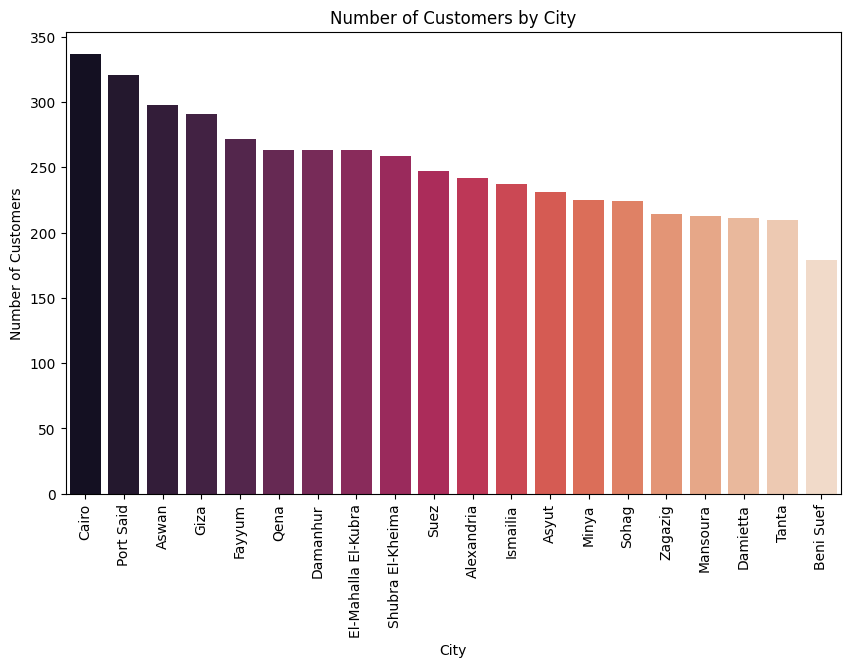

In [45]:
# how many customers for each city
plt.figure(figsize=(10, 6))
sns.countplot(data=transactions_df, x='city_name' ,palette="rocket", order=transactions_df['city_name'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by City')

<ipython-input-48-15447a5063e7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions_df, x='gender_name',palette='Paired')


Text(0.5, 1.0, 'Number of Customers by Gender')

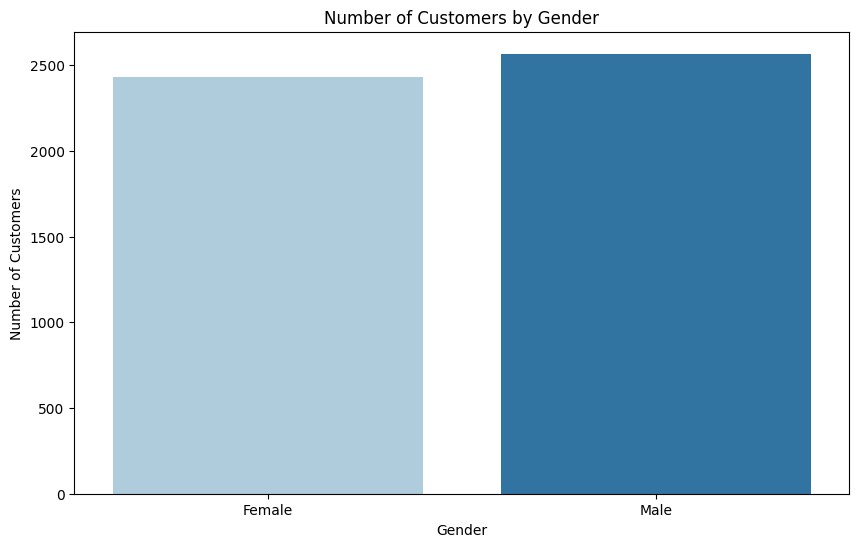

In [48]:
# how many male and female
plt.figure(figsize=(10, 6))
sns.countplot(data=transactions_df, x='gender_name',palette='Paired')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Gender')

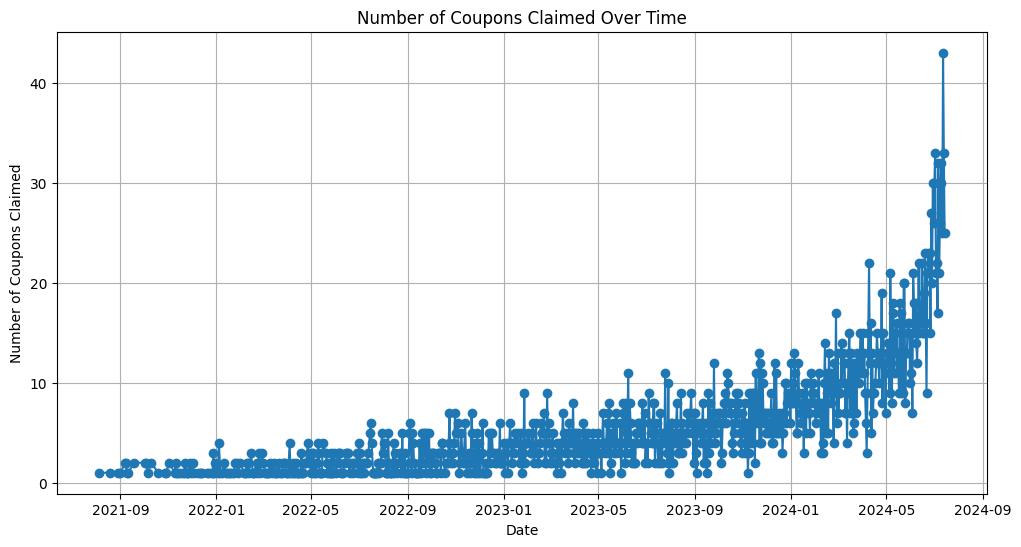

In [54]:
# Count the number of coupons claimed per day
coupons_per_day = transactions_df.groupby('transaction_date').size()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(coupons_per_day.index, coupons_per_day.values,marker='o')
plt.xlabel("Date")
plt.ylabel("Number of Coupons Claimed")
plt.title("Number of Coupons Claimed Over Time")
plt.grid(True)
plt.show()

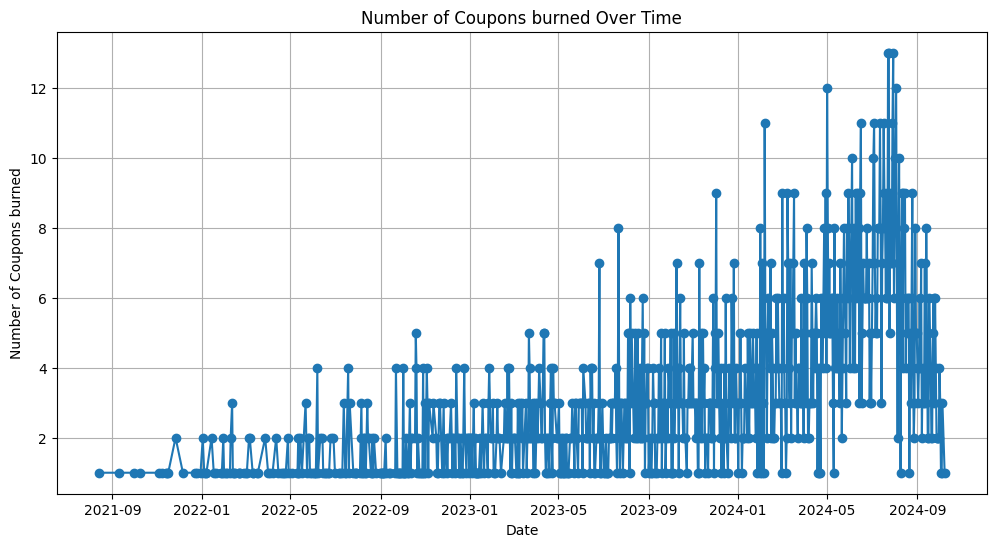

In [55]:
# Count the number of coupons burned
coupons_per_day = transactions_df.groupby('burn_date').size()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(coupons_per_day.index, coupons_per_day.values,marker='o')
plt.xlabel("Date")
plt.ylabel("Number of Coupons burned")
plt.title("Number of Coupons burned Over Time")
plt.grid(True)
plt.show()

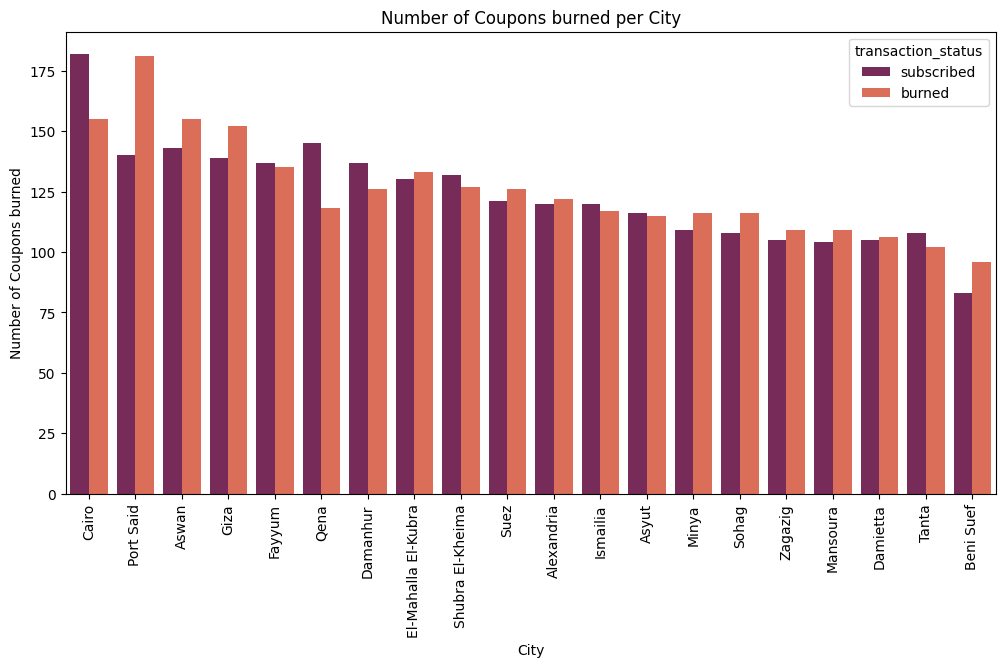

In [59]:
# Count burned and subscribed coupons per city
plt.figure(figsize=(12, 6))
sns.countplot(data=transactions_df, x='city_name', hue='transaction_status',
palette='rocket', order=transactions_df['city_name'].value_counts().index)
plt.xlabel("City")
plt.ylabel("Number of Coupons burned")
plt.title("Number of Coupons burned per City")
plt.xticks(rotation=90)
plt.show()


In [61]:
!pip install dash
from IPython.display import clear_output
clear_output()

In [75]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px


# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the Dashboard
app.layout = html.Div([
    html.H1("E-commerce Customers Segmentation Dashboard"),

    # Dropdown for selecting visualization
    dcc.Dropdown(
        id='chart-dropdown',
        options=[
            {'label': 'Customer Gender Distribution', 'value': 'gender'},
            {'label': 'Customer City Distribution', 'value': 'city'},
            {'label': 'Coupon Usage Over Time', 'value': 'time_series'},
            {'label': 'Top Cities/Branches (Coupon Burn)', 'value': 'top_branches'}
        ],
        value='gender',
        clearable=False
    ),

    # Graph component
    dcc.Graph(id='chart-output')
])

# Callback to update the graph
@app.callback(
    Output('chart-output', 'figure'),
    Input('chart-dropdown', 'value')
)
def update_chart(selected_chart):
    if selected_chart == 'gender':
        fig = px.pie(transactions_df, names='gender_name', title='Customer Gender Distribution', color_discrete_sequence=["#58508d", "#bc5090"])
    elif selected_chart == 'city':
        fig = px.pie(transactions_df, names='city_name', title='Customer City Distribution')
    elif selected_chart == 'time_series':
        time_series_df = transactions_df.groupby('transaction_date').size().reset_index(name='count')
        fig = px.line(time_series_df, x='transaction_date', y='count', title='Coupon Usage Over Time')
    elif selected_chart == 'top_branches':
        top_branches_df = transactions_df[transactions_df['transaction_status'] == 'burned'].groupby('branch_id').size().reset_index(name='count')
        fig = px.bar(top_branches_df, x='branch_id', y='count', title='Top Branches for Coupon Burns')
    elif selected_chart == 'top_cities':
        top_cities_df = transactions_df[transactions_df['transaction_status'] == 'burned'].groupby('city_name').size().reset_index(name='count')
        fig = px.bar(top_cities_df, x='city_name', y='count', title='Top Cities for Coupon Burns')

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

# K-means

In [78]:
# Calculate coupon usage frequency per customer
customer_stats = transactions_df.groupby("customer_id").agg(
    total_transactions=("transaction_id", "count"),
    burned_coupons=("burn_date", "count"),
    city_id=("city_name", "first"),
    gender_id=("gender_name", "first")
).reset_index()

customer_stats["burn_rate"] = customer_stats["burned_coupons"] / customer_stats["total_transactions"]

In [79]:
# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(customer_stats[["total_transactions", "burned_coupons", "burn_rate"]])

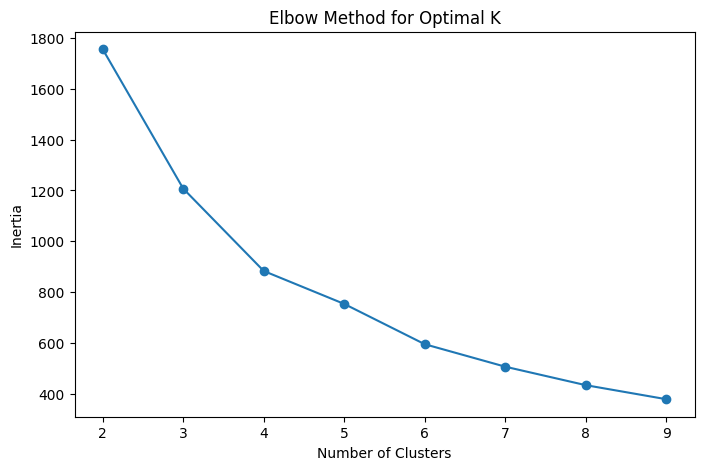

In [80]:
# Finding optimal K using Elbow Method
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [81]:
# Choose optimal K
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X)
customer_stats["cluster"] = kmeans.labels_

In [82]:
# Evaluate Clustering
silhouette_avg = silhouette_score(X, customer_stats["cluster"])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.40


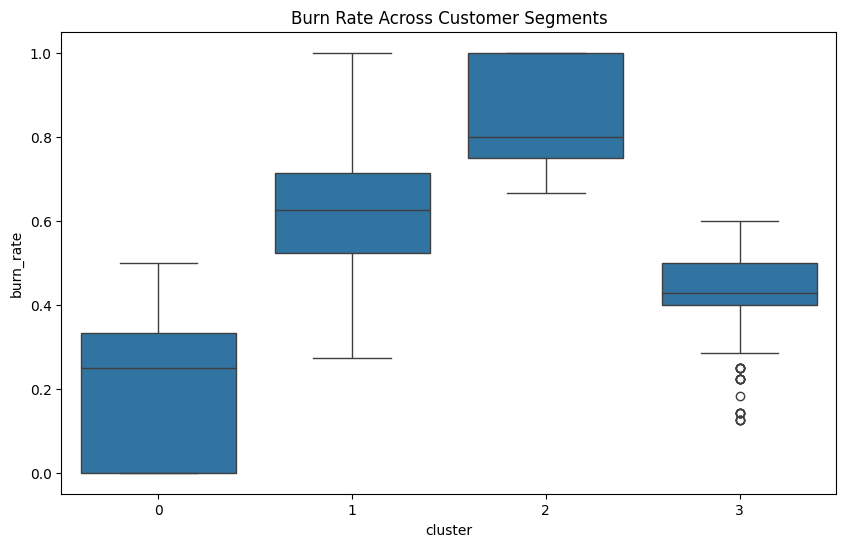

In [86]:
# Cluster Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x="cluster", y="burn_rate", data=customer_stats)
plt.title("Burn Rate Across Customer Segments")
plt.show()

In [84]:
# Print sample of each segment
for cluster in sorted(customer_stats["cluster"].unique()):
    print(f"Segment {cluster}:")
    print(customer_stats[customer_stats["cluster"] == cluster].head())
    print("-" * 50)

Segment 0:
    customer_id  total_transactions  burned_coupons              city_id  \
1             2                   3               1                Sohag   
2             3                   5               1                Aswan   
3             4                   1               0             Ismailia   
9            11                   2               0  El-Mahalla El-Kubra   
13           15                   1               0                 Suez   

   gender_id  burn_rate  cluster  
1     Female   0.333333        0  
2       Male   0.200000        0  
3     Female   0.000000        0  
9       Male   0.000000        0  
13      Male   0.000000        0  
--------------------------------------------------
Segment 1:
    customer_id  total_transactions  burned_coupons           city_id  \
8            10                   8               5  Shubra El-Kheima   
10           12                   9               4              Giza   
11           13                  10      